In [22]:
import sys
import os

sys.path.append("Methods/GroHess/Two layers")
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "/Methods/GroHess/Two layers/data"

HPO_name = "greedy_HPO"
method_name = "GroHess_two_layers"
benchmark_name = "pMNIST"

In [23]:
from lib.abstract_torch import get_device
from lib.dataloader import get_task_loaders
from lib.models import ANN
from lib.train import train
from lib.test import test
from HPO_lib.visualize import visualize_accs_matrix, visualize_avg_acc_curve, visualize_best_params, visualize_val_accs_matrix, visualize_accuracy_through_benchmarks, visualize_violin

import numpy as np
import copy
import optuna
from functools import partial

import warnings
warnings.filterwarnings('ignore')

In [24]:
device = get_device(1)

In [25]:
# Must tune hyperparameters
num_tasks = 5
train_percentage = 0.8
difficulty = "standard"
grow_from = "output"
n_trials = 10
num_val_benchmarks = 5

# Set the percentile threshold for building Hessian and gradient masks
hessian_percentile = 95
grad_percentile = 95

# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden_root = 100
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

# Other hyperparameters
#num_epochs = 3
#lr = 1e-3

Fixed hyperparameters :
- Start by growing left layer at each new task to handle and then alternate
- Growth trigger :
    - delay_growth (at each new task to handle)
    - delay_growth
    - should_we_grow

# HPO

## Reproducibility

In [26]:
random_seed = 88
permutation_random_seeds = list(range(num_tasks))

## Get p-MNIST loaders

In [27]:
train_loaders_list, val_loaders_list, test_loaders_list = [], [], []
for random_seed in permutation_random_seeds :
    train_loader, val_loader, test_loader = get_task_loaders(data_path, batch_size, random_seed, train_percentage=train_percentage, difficulty=difficulty, download=False)
    train_loaders_list += [train_loader]
    val_loaders_list += [val_loader]
    test_loaders_list += [test_loader]

## Perform HPO

In [28]:
def objective(model, task_number, params, device, trial) :

    # Set HPs
    lr = trial.suggest_float("lr", 5e-5, 2e-3)
    num_epochs = trial.suggest_int("num_epochs", 2, 6)

    # Copy the model to perform HPO
    model_copy = copy.deepcopy(model)
    
    # Train
    overall_masks, is_first_task = params
    
    train_loader = train_loaders_list[task_number]

    _ = train(model_copy, grow_from, overall_masks, is_first_task,
                      loss_name, optimizer_name, lr, num_epochs, batch_size,
                      hessian_percentile, grad_percentile,
                      train_loader,
                      device, random_seed, 
                      verbose=0)

    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test(model_copy, val_loaders_list[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    score = np.mean(test_accs)
    
    return score

In [29]:
def retrain_and_save_with_best_HPs (model, params, best_params, train_loader) :
    lr = best_params["lr"]
    num_epochs = best_params["num_epochs"]
    
    overall_masks, is_first_task = params

    # Train
    overall_masks, _, _ = train(model, grow_from, overall_masks, is_first_task,
                      loss_name, optimizer_name, lr, num_epochs, batch_size,
                      hessian_percentile, grad_percentile,
                      train_loader,
                      device, random_seed, 
                      verbose=2)
    
    return overall_masks

In [30]:
def call_greedy_HPO(n_trials) :
    # Initialize model
    model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

    # Intialize mask
    if grow_from == "input" :
        overall_masks = [np.ones_like(model.fc1.weight.data.cpu().numpy()),
                        np.ones_like(model.fc2.weight.data.cpu().numpy())]
    else :
        overall_masks = [np.ones_like(model.fc2.weight.data.cpu().numpy()),
                        np.ones_like(model.fc3.weight.data.cpu().numpy())]
            
    # Initialize variable to store the best HPs and the scores
    best_params_list = []
    test_accs_matrix = np.zeros((num_tasks, num_tasks))

    for task_number in range(0,num_tasks) :

        # Verbose
        print("\n" + "-"*50)
        print(f"LEARNING TASK {task_number+1}")

        # Perform HPO
        storage = optuna.storages.InMemoryStorage()
        study = optuna.create_study(storage=storage,
                                    study_name=f"Search number {task_number+1}",
                                    sampler=optuna.samplers.TPESampler(seed=random_seed),
                                    direction = "maximize")
        
        is_first_task = True if task_number==0 else False
        params = overall_masks, is_first_task
        partial_objective = partial(objective, model, task_number, params, device)
        study.optimize(partial_objective,
                    n_trials=n_trials,
                    timeout=3600)

        # Retrain and save a model with the best params
        best_params = study.best_trial.params
        best_params_list += [best_params]
        overall_masks = retrain_and_save_with_best_HPs(model, params, best_params, train_loaders_list[task_number]) 
        
        # Test on each task
        for j in range(num_tasks) :
            test_accs_matrix[task_number,j] = round(test(model, test_loaders_list[j], batch_size, device),2)
    
    return test_accs_matrix, best_params_list, model

In [31]:
test_accs_matrix, best_params_list, model = call_greedy_HPO(n_trials)

[I 2024-07-04 10:38:26,966] A new study created in memory with name: Search number 1



--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:20<00:00,  5.14s/it]
[I 2024-07-04 10:38:48,712] Trial 0 finished with value: 96.43903225806451 and parameters: {'lr': 0.0019357081860766697, 'num_epochs': 4}. Best is trial 0 with value: 96.43903225806451.
100%|██████████| 5/5 [00:25<00:00,  5.13s/it]
[I 2024-07-04 10:39:15,577] Trial 1 finished with value: 96.79247311827956 and parameters: {'lr': 0.0019467345019315244, 'num_epochs': 5}. Best is trial 1 with value: 96.79247311827956.
100%|██████████| 3/3 [00:15<00:00,  5.13s/it]
[I 2024-07-04 10:39:32,169] Trial 2 finished with value: 95.8420430107527 and parameters: {'lr': 0.001410571207964678, 'num_epochs': 3}. Best is trial 1 with value: 96.79247311827956.
100%|██████████| 2/2 [00:10<00:00,  5.12s/it]
[I 2024-07-04 10:39:43,604] Trial 3 finished with value: 95.21172043010753 and parameters: {'lr': 0.0019537351868136716, 'num_epochs': 2}. Best is trial 1 with value: 96.79247311827956.
100%|██████████| 4/4 [00:20<00:00,  5.12s/it]
[I 2024-07-04 10:40:05,298] 

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 20%|██        | 1/5 [00:05<00:20,  5.18s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 40%|████      | 2/5 [00:10<00:15,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 60%|██████    | 3/5 [00:15<00:10,  5.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 80%|████████  | 4/5 [00:20<00:05,  5.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|██████████| 5/5 [00:25<00:00,  5.14s/it]
[I 2024-07-04 10:42:29,547] A new study created in memory with name: Search number 2



--------------------------------------------------
LEARNING TASK 2


100%|██████████| 4/4 [00:20<00:00,  5.16s/it]
[I 2024-07-04 10:42:52,594] Trial 0 finished with value: 93.11564516129033 and parameters: {'lr': 0.0019357081860766697, 'num_epochs': 4}. Best is trial 0 with value: 93.11564516129033.
100%|██████████| 5/5 [00:25<00:00,  5.14s/it]
[I 2024-07-04 10:43:20,720] Trial 1 finished with value: 93.38424731182798 and parameters: {'lr': 0.0019467345019315244, 'num_epochs': 5}. Best is trial 1 with value: 93.38424731182798.
100%|██████████| 3/3 [00:15<00:00,  5.15s/it]
[I 2024-07-04 10:43:38,562] Trial 2 finished with value: 95.1489247311828 and parameters: {'lr': 0.001410571207964678, 'num_epochs': 3}. Best is trial 2 with value: 95.1489247311828.
100%|██████████| 2/2 [00:10<00:00,  5.34s/it]
[I 2024-07-04 10:43:51,654] Trial 3 finished with value: 94.57354838709678 and parameters: {'lr': 0.0019537351868136716, 'num_epochs': 2}. Best is trial 2 with value: 95.1489247311828.
100%|██████████| 4/4 [00:21<00:00,  5.39s/it]
[I 2024-07-04 10:44:15,606] Tr

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.42s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.43s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


100%|██████████| 3/3 [00:16<00:00,  5.42s/it]
[I 2024-07-04 10:46:41,800] A new study created in memory with name: Search number 3



--------------------------------------------------
LEARNING TASK 3


100%|██████████| 4/4 [00:21<00:00,  5.42s/it]
[I 2024-07-04 10:47:07,097] Trial 0 finished with value: 83.3220430107527 and parameters: {'lr': 0.0019357081860766697, 'num_epochs': 4}. Best is trial 0 with value: 83.3220430107527.
100%|██████████| 5/5 [00:26<00:00,  5.38s/it]
[I 2024-07-04 10:47:37,597] Trial 1 finished with value: 82.86297491039426 and parameters: {'lr': 0.0019467345019315244, 'num_epochs': 5}. Best is trial 0 with value: 83.3220430107527.
100%|██████████| 3/3 [00:15<00:00,  5.16s/it]
[I 2024-07-04 10:47:56,699] Trial 2 finished with value: 87.13609318996419 and parameters: {'lr': 0.001410571207964678, 'num_epochs': 3}. Best is trial 2 with value: 87.13609318996419.
100%|██████████| 2/2 [00:10<00:00,  5.16s/it]
[I 2024-07-04 10:48:10,614] Trial 3 finished with value: 84.35827956989247 and parameters: {'lr': 0.0019537351868136716, 'num_epochs': 2}. Best is trial 2 with value: 87.13609318996419.
100%|██████████| 4/4 [00:20<00:00,  5.14s/it]
[I 2024-07-04 10:48:34,758] Tr

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


 25%|██▌       | 1/4 [00:05<00:15,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


 50%|█████     | 2/4 [00:10<00:10,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


 75%|███████▌  | 3/4 [00:15<00:05,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


100%|██████████| 4/4 [00:20<00:00,  5.16s/it]
[I 2024-07-04 10:51:06,349] A new study created in memory with name: Search number 4



--------------------------------------------------
LEARNING TASK 4


100%|██████████| 4/4 [00:20<00:00,  5.14s/it]
[I 2024-07-04 10:51:31,740] Trial 0 finished with value: 74.37854838709677 and parameters: {'lr': 0.0019357081860766697, 'num_epochs': 4}. Best is trial 0 with value: 74.37854838709677.
100%|██████████| 5/5 [00:25<00:00,  5.16s/it]
[I 2024-07-04 10:52:02,355] Trial 1 finished with value: 76.84838709677419 and parameters: {'lr': 0.0019467345019315244, 'num_epochs': 5}. Best is trial 1 with value: 76.84838709677419.
100%|██████████| 3/3 [00:15<00:00,  5.15s/it]
[I 2024-07-04 10:52:22,614] Trial 2 finished with value: 82.67201612903227 and parameters: {'lr': 0.001410571207964678, 'num_epochs': 3}. Best is trial 2 with value: 82.67201612903227.
100%|██████████| 2/2 [00:10<00:00,  5.13s/it]
[I 2024-07-04 10:52:37,692] Trial 3 finished with value: 82.66577956989246 and parameters: {'lr': 0.0019537351868136716, 'num_epochs': 2}. Best is trial 2 with value: 82.67201612903227.
100%|██████████| 4/4 [00:20<00:00,  5.15s/it]
[I 2024-07-04 10:53:03,101]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


 17%|█▋        | 1/6 [00:05<00:25,  5.19s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 2/6 [00:10<00:20,  5.18s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


 50%|█████     | 3/6 [00:15<00:15,  5.18s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 4/6 [00:20<00:10,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


 83%|████████▎ | 5/6 [00:25<00:05,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


100%|██████████| 6/6 [00:31<00:00,  5.17s/it]
[I 2024-07-04 10:55:51,512] A new study created in memory with name: Search number 5



--------------------------------------------------
LEARNING TASK 5


100%|██████████| 4/4 [00:20<00:00,  5.15s/it]
[I 2024-07-04 10:56:18,145] Trial 0 finished with value: 77.85316129032259 and parameters: {'lr': 0.0019357081860766697, 'num_epochs': 4}. Best is trial 0 with value: 77.85316129032259.
100%|██████████| 5/5 [00:25<00:00,  5.16s/it]
[I 2024-07-04 10:56:49,980] Trial 1 finished with value: 71.51374193548386 and parameters: {'lr': 0.0019467345019315244, 'num_epochs': 5}. Best is trial 0 with value: 77.85316129032259.
100%|██████████| 3/3 [00:15<00:00,  5.17s/it]
[I 2024-07-04 10:57:11,524] Trial 2 finished with value: 80.94922580645162 and parameters: {'lr': 0.001410571207964678, 'num_epochs': 3}. Best is trial 2 with value: 80.94922580645162.
100%|██████████| 2/2 [00:10<00:00,  5.16s/it]
[I 2024-07-04 10:57:27,873] Trial 3 finished with value: 79.10096774193548 and parameters: {'lr': 0.0019537351868136716, 'num_epochs': 2}. Best is trial 2 with value: 80.94922580645162.
100%|██████████| 4/4 [00:20<00:00,  5.16s/it]
[I 2024-07-04 10:57:54,586]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.18s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 148
fc2 : in = 148, out = 100
fc3 : in = 100, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


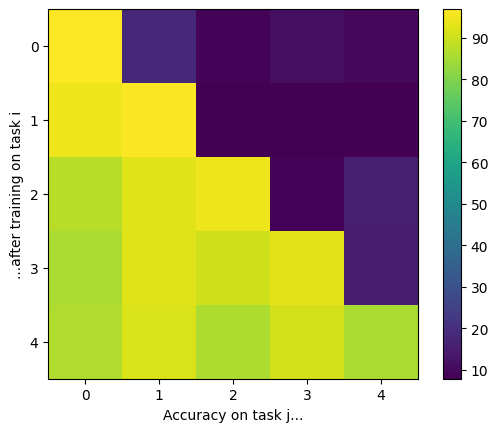

In [32]:
visualize_accs_matrix(test_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

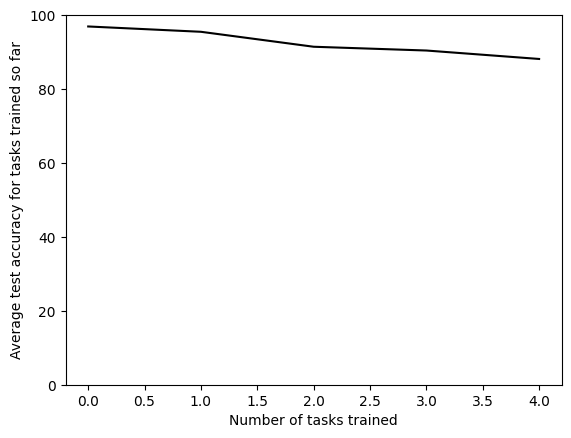

In [33]:
visualize_avg_acc_curve(test_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

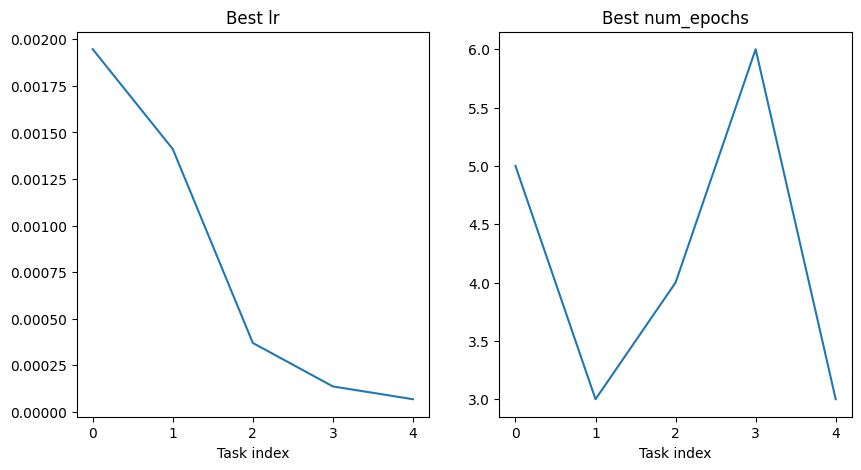

In [34]:
visualize_best_params(best_params_list, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

# Validation benchmarks

## Reproducibility

In [43]:
permutation_random_seeds_list = [list(range(num_tasks*(i), num_tasks*(i+1))) for i in range(0,num_val_benchmarks+1)]

## Get p-MNIST loaders

In [44]:
train_loaders_list_list = []
test_loaders_list_list = []
for i in range(num_val_benchmarks+1) :
    permutation_random_seeds = permutation_random_seeds_list[i]
    train_loaders_list = []
    test_loaders_list = []
    for random_seed in permutation_random_seeds :
        train_loader, _, test_loader = get_task_loaders(data_path, batch_size, random_seed, train_percentage=train_percentage, difficulty="difficult", download=False)
        train_loaders_list += [train_loader]
        test_loaders_list += [test_loader]
    train_loaders_list_list += [train_loaders_list]
    test_loaders_list_list += [test_loaders_list]

In [45]:
val_accs_matrix = np.zeros((num_val_benchmarks+2, num_tasks))

In [46]:
def train_with_best_params (best_params_list, train_loaders_list) :
    # Initialize model
    benchmark_model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

    # Intialize mask
    if grow_from == "input" :
        overall_masks = [np.ones_like(benchmark_model.fc1.weight.data.cpu().numpy()),
                        np.ones_like(benchmark_model.fc2.weight.data.cpu().numpy())]
    else :
        overall_masks = [np.ones_like(benchmark_model.fc2.weight.data.cpu().numpy()),
                        np.ones_like(benchmark_model.fc3.weight.data.cpu().numpy())]

    for task_number in range(0,num_tasks) :

        # Verbose
        print("\n" + "-"*50)
        print(f"LEARNING TASK {task_number+1}")

        # Retrain and save a model with the best params
        is_first_task = True if task_number==0 else False
        params = overall_masks, is_first_task
        overall_masks = retrain_and_save_with_best_HPs(benchmark_model, params, best_params_list[task_number], train_loaders_list[task_number]) 
    
    return benchmark_model

In [47]:
for i in range(num_val_benchmarks+2) :
    benchmark_number = 0 if i <= 1 else i-1
    print("\n" + "="*50)
    print(f"BENCHMARK {benchmark_number}")
    # Train model with best params obtained through HPO on benchmark 0
    if i != 0 :
        train_loaders_list = train_loaders_list_list[benchmark_number]
        benchmark_model = train_with_best_params (best_params_list, train_loaders_list)
    else : 
        benchmark_model = copy.deepcopy(model)
    # Test on each task
    test_loaders_list = test_loaders_list_list[benchmark_number]
    for j in range(num_tasks) :
        val_accs_matrix[i,j] = round(test(benchmark_model, test_loaders_list_list[benchmark_number][j], batch_size, device),2)


BENCHMARK 0

BENCHMARK 0

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/5 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 20%|██        | 1/5 [00:05<00:20,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 40%|████      | 2/5 [00:10<00:15,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 60%|██████    | 3/5 [00:15<00:10,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 80%|████████  | 4/5 [00:20<00:05,  5.18s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|██████████| 5/5 [00:25<00:00,  5.18s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.26s/it]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.26s/it]

In and out sizes :
fc1 : in = 784, out = 178
fc2 : in = 178, out = 100
fc3 : in = 100, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.27s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 178
fc2 : in = 178, out = 100
fc3 : in = 100, out = 10


 25%|██▌       | 1/4 [00:05<00:15,  5.18s/it]

In and out sizes :
fc1 : in = 784, out = 178
fc2 : in = 178, out = 100
fc3 : in = 100, out = 10


 50%|█████     | 2/4 [00:10<00:10,  5.23s/it]

In and out sizes :
fc1 : in = 784, out = 178
fc2 : in = 178, out = 100
fc3 : in = 100, out = 10


 75%|███████▌  | 3/4 [00:15<00:05,  5.20s/it]

In and out sizes :
fc1 : in = 784, out = 178
fc2 : in = 178, out = 100
fc3 : in = 100, out = 10


100%|██████████| 4/4 [00:20<00:00,  5.19s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 178
fc2 : in = 178, out = 100
fc3 : in = 100, out = 10


 17%|█▋        | 1/6 [00:05<00:27,  5.42s/it]

In and out sizes :
fc1 : in = 784, out = 178
fc2 : in = 178, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 2/6 [00:10<00:21,  5.31s/it]

In and out sizes :
fc1 : in = 784, out = 178
fc2 : in = 178, out = 100
fc3 : in = 100, out = 10


 50%|█████     | 3/6 [00:15<00:15,  5.29s/it]

In and out sizes :
fc1 : in = 784, out = 178
fc2 : in = 178, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 4/6 [00:21<00:10,  5.23s/it]

In and out sizes :
fc1 : in = 784, out = 178
fc2 : in = 178, out = 100
fc3 : in = 100, out = 10


 83%|████████▎ | 5/6 [00:26<00:05,  5.22s/it]

In and out sizes :
fc1 : in = 784, out = 245
fc2 : in = 245, out = 100
fc3 : in = 100, out = 10


100%|██████████| 6/6 [00:31<00:00,  5.25s/it]



--------------------------------------------------
LEARNING TASK 5


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 245
fc2 : in = 245, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.25s/it]

In and out sizes :
fc1 : in = 784, out = 245
fc2 : in = 245, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.21s/it]

In and out sizes :
fc1 : in = 784, out = 341
fc2 : in = 341, out = 138
fc3 : in = 138, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]



BENCHMARK 1

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/5 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 20%|██        | 1/5 [00:05<00:20,  5.19s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 40%|████      | 2/5 [00:10<00:15,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 60%|██████    | 3/5 [00:15<00:10,  5.23s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 80%|████████  | 4/5 [00:20<00:05,  5.26s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|██████████| 5/5 [00:26<00:00,  5.23s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.24s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.23s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.24s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 140
fc2 : in = 140, out = 100
fc3 : in = 100, out = 10


 25%|██▌       | 1/4 [00:05<00:15,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 140
fc2 : in = 140, out = 100
fc3 : in = 100, out = 10


 50%|█████     | 2/4 [00:10<00:10,  5.22s/it]

In and out sizes :
fc1 : in = 784, out = 192
fc2 : in = 192, out = 100
fc3 : in = 100, out = 10


 75%|███████▌  | 3/4 [00:15<00:05,  5.22s/it]

In and out sizes :
fc1 : in = 784, out = 192
fc2 : in = 192, out = 100
fc3 : in = 100, out = 10


100%|██████████| 4/4 [00:20<00:00,  5.20s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 192
fc2 : in = 192, out = 100
fc3 : in = 100, out = 10


 17%|█▋        | 1/6 [00:05<00:25,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 192
fc2 : in = 192, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 2/6 [00:10<00:20,  5.18s/it]

In and out sizes :
fc1 : in = 784, out = 287
fc2 : in = 287, out = 100
fc3 : in = 100, out = 10


 50%|█████     | 3/6 [00:15<00:15,  5.19s/it]

In and out sizes :
fc1 : in = 784, out = 287
fc2 : in = 287, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 4/6 [00:20<00:10,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 287
fc2 : in = 287, out = 100
fc3 : in = 100, out = 10


 83%|████████▎ | 5/6 [00:25<00:05,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 287
fc2 : in = 287, out = 100
fc3 : in = 100, out = 10


100%|██████████| 6/6 [00:30<00:00,  5.16s/it]



--------------------------------------------------
LEARNING TASK 5


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 287
fc2 : in = 287, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 287
fc2 : in = 287, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.18s/it]

In and out sizes :
fc1 : in = 784, out = 287
fc2 : in = 287, out = 100
fc3 : in = 100, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]



BENCHMARK 2

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/5 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 20%|██        | 1/5 [00:05<00:20,  5.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 40%|████      | 2/5 [00:10<00:15,  5.32s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 60%|██████    | 3/5 [00:15<00:10,  5.27s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 80%|████████  | 4/5 [00:20<00:05,  5.22s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|██████████| 5/5 [00:26<00:00,  5.21s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.28s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.23s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|██▌       | 1/4 [00:05<00:15,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|█████     | 2/4 [00:10<00:10,  5.21s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 75%|███████▌  | 3/4 [00:15<00:05,  5.19s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 112
fc3 : in = 112, out = 10


100%|██████████| 4/4 [00:20<00:00,  5.19s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 112
fc3 : in = 112, out = 10


 17%|█▋        | 1/6 [00:05<00:26,  5.20s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 112
fc3 : in = 112, out = 10


 33%|███▎      | 2/6 [00:10<00:20,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 112
fc3 : in = 112, out = 10


 50%|█████     | 3/6 [00:15<00:15,  5.28s/it]

In and out sizes :
fc1 : in = 784, out = 223
fc2 : in = 223, out = 112
fc3 : in = 112, out = 10


 67%|██████▋   | 4/6 [00:20<00:10,  5.26s/it]

In and out sizes :
fc1 : in = 784, out = 377
fc2 : in = 377, out = 112
fc3 : in = 112, out = 10


 83%|████████▎ | 5/6 [00:26<00:05,  5.26s/it]

In and out sizes :
fc1 : in = 784, out = 377
fc2 : in = 377, out = 112
fc3 : in = 112, out = 10


100%|██████████| 6/6 [00:31<00:00,  5.23s/it]



--------------------------------------------------
LEARNING TASK 5


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 377
fc2 : in = 377, out = 112
fc3 : in = 112, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.23s/it]

In and out sizes :
fc1 : in = 784, out = 377
fc2 : in = 377, out = 112
fc3 : in = 112, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.20s/it]

In and out sizes :
fc1 : in = 784, out = 642
fc2 : in = 642, out = 112
fc3 : in = 112, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]



BENCHMARK 3

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/5 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 20%|██        | 1/5 [00:05<00:20,  5.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 40%|████      | 2/5 [00:10<00:15,  5.18s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 60%|██████    | 3/5 [00:15<00:10,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 80%|████████  | 4/5 [00:20<00:05,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|██████████| 5/5 [00:25<00:00,  5.16s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.15s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|██▌       | 1/4 [00:05<00:15,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 50%|█████     | 2/4 [00:10<00:10,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 75%|███████▌  | 3/4 [00:15<00:05,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


100%|██████████| 4/4 [00:20<00:00,  5.15s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 17%|█▋        | 1/6 [00:05<00:25,  5.14s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 2/6 [00:10<00:20,  5.13s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 50%|█████     | 3/6 [00:15<00:15,  5.24s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 4/6 [00:20<00:10,  5.20s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 83%|████████▎ | 5/6 [00:25<00:05,  5.18s/it]

In and out sizes :
fc1 : in = 784, out = 146
fc2 : in = 146, out = 100
fc3 : in = 100, out = 10


100%|██████████| 6/6 [00:31<00:00,  5.23s/it]



--------------------------------------------------
LEARNING TASK 5


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 146
fc2 : in = 146, out = 110
fc3 : in = 110, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.27s/it]

In and out sizes :
fc1 : in = 784, out = 146
fc2 : in = 146, out = 110
fc3 : in = 110, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.32s/it]

In and out sizes :
fc1 : in = 784, out = 146
fc2 : in = 146, out = 110
fc3 : in = 110, out = 10


100%|██████████| 3/3 [00:16<00:00,  5.35s/it]



BENCHMARK 4

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/5 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 20%|██        | 1/5 [00:05<00:21,  5.47s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 40%|████      | 2/5 [00:10<00:16,  5.46s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 60%|██████    | 3/5 [00:16<00:10,  5.42s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 80%|████████  | 4/5 [00:21<00:05,  5.32s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|██████████| 5/5 [00:26<00:00,  5.32s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 102
fc2 : in = 102, out = 100
fc3 : in = 100, out = 10


 25%|██▌       | 1/4 [00:05<00:15,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 102
fc2 : in = 102, out = 100
fc3 : in = 100, out = 10


 50%|█████     | 2/4 [00:10<00:10,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 138
fc2 : in = 138, out = 100
fc3 : in = 100, out = 10


 75%|███████▌  | 3/4 [00:15<00:05,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 138
fc2 : in = 138, out = 100
fc3 : in = 100, out = 10


100%|██████████| 4/4 [00:20<00:00,  5.16s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 138
fc2 : in = 138, out = 100
fc3 : in = 100, out = 10


 17%|█▋        | 1/6 [00:05<00:25,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 138
fc2 : in = 138, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 2/6 [00:10<00:20,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 138
fc2 : in = 138, out = 100
fc3 : in = 100, out = 10


 50%|█████     | 3/6 [00:15<00:15,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 205
fc2 : in = 205, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 4/6 [00:20<00:10,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 205
fc2 : in = 205, out = 100
fc3 : in = 100, out = 10


 83%|████████▎ | 5/6 [00:25<00:05,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 335
fc2 : in = 335, out = 100
fc3 : in = 100, out = 10


100%|██████████| 6/6 [00:30<00:00,  5.16s/it]



--------------------------------------------------
LEARNING TASK 5


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 335
fc2 : in = 335, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.14s/it]

In and out sizes :
fc1 : in = 784, out = 335
fc2 : in = 335, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 335
fc2 : in = 335, out = 100
fc3 : in = 100, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.15s/it]



BENCHMARK 5

--------------------------------------------------
LEARNING TASK 1


  0%|          | 0/5 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 20%|██        | 1/5 [00:05<00:20,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 40%|████      | 2/5 [00:10<00:15,  5.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 60%|██████    | 3/5 [00:15<00:10,  5.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 80%|████████  | 4/5 [00:20<00:05,  5.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|██████████| 5/5 [00:25<00:00,  5.14s/it]



--------------------------------------------------
LEARNING TASK 2


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 134
fc2 : in = 134, out = 117
fc3 : in = 117, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.15s/it]



--------------------------------------------------
LEARNING TASK 3


  0%|          | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 134
fc2 : in = 134, out = 117
fc3 : in = 117, out = 10


 25%|██▌       | 1/4 [00:05<00:15,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 140
fc2 : in = 140, out = 117
fc3 : in = 117, out = 10


 50%|█████     | 2/4 [00:10<00:10,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 140
fc2 : in = 140, out = 117
fc3 : in = 117, out = 10


 75%|███████▌  | 3/4 [00:15<00:05,  5.15s/it]

In and out sizes :
fc1 : in = 784, out = 140
fc2 : in = 140, out = 117
fc3 : in = 117, out = 10


100%|██████████| 4/4 [00:20<00:00,  5.15s/it]



--------------------------------------------------
LEARNING TASK 4


  0%|          | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 140
fc2 : in = 140, out = 117
fc3 : in = 117, out = 10


 17%|█▋        | 1/6 [00:05<00:25,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 140
fc2 : in = 140, out = 117
fc3 : in = 117, out = 10


 33%|███▎      | 2/6 [00:10<00:20,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 180
fc2 : in = 180, out = 117
fc3 : in = 117, out = 10


 50%|█████     | 3/6 [00:15<00:15,  5.17s/it]

In and out sizes :
fc1 : in = 784, out = 180
fc2 : in = 180, out = 117
fc3 : in = 117, out = 10


 67%|██████▋   | 4/6 [00:20<00:10,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 180
fc2 : in = 180, out = 117
fc3 : in = 117, out = 10


 83%|████████▎ | 5/6 [00:25<00:05,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 180
fc2 : in = 180, out = 117
fc3 : in = 117, out = 10


100%|██████████| 6/6 [00:30<00:00,  5.16s/it]



--------------------------------------------------
LEARNING TASK 5


  0%|          | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 180
fc2 : in = 180, out = 117
fc3 : in = 117, out = 10


 33%|███▎      | 1/3 [00:05<00:10,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 180
fc2 : in = 180, out = 117
fc3 : in = 117, out = 10


 67%|██████▋   | 2/3 [00:10<00:05,  5.16s/it]

In and out sizes :
fc1 : in = 784, out = 180
fc2 : in = 180, out = 117
fc3 : in = 117, out = 10


100%|██████████| 3/3 [00:15<00:00,  5.16s/it]


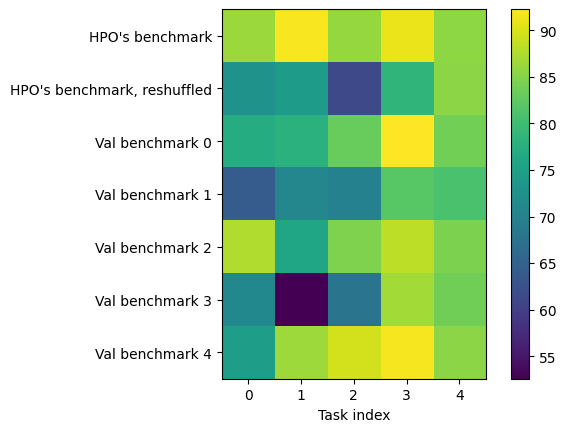

In [48]:
visualize_val_accs_matrix(val_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

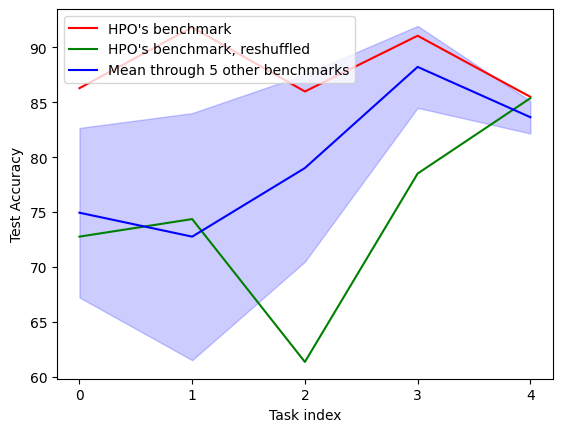

In [49]:
visualize_accuracy_through_benchmarks(val_accs_matrix, HPO_name, num_val_benchmarks, method_name, grow_from, benchmark_name, difficulty, savefig=True)

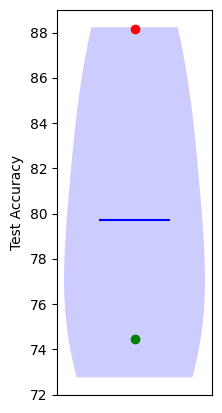

In [50]:
visualize_violin(val_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)